In [1]:
import base64
import datetime
import json
import os
import random
import time

import scipy
from scipy import ndimage
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import statsmodels as sm
from pylab import rcParams
from pylab import *
from matplotlib.dates import date2num , DateFormatter
from PIL import Image

np.random.seed(1337)

%matplotlib inline
sns.set(font_scale=1.0)
rcParams['figure.figsize'] = 8, 6
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

pd.options.display.max_colwidth = 1000

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Load the Data

In [2]:
raw_data = pd.read_json('tmp/raw_data.json')
d = pd.read_json('tmp/raw_data.json')
raw_data.index.name = 'id'
d = raw_data[['bathrooms']]
print len(d)

124011


In [3]:
interest = raw_data.interest_level.value_counts()
print 100 * interest / interest.sum()

low       69.468309
medium    22.752877
high       7.778813
Name: interest_level, dtype: float64


In [4]:
d.dtypes

bathrooms    float64
dtype: object

In [5]:
d.bathrooms.describe()

count    124011.000000
mean          1.212622
std           0.595209
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         112.000000
Name: bathrooms, dtype: float64

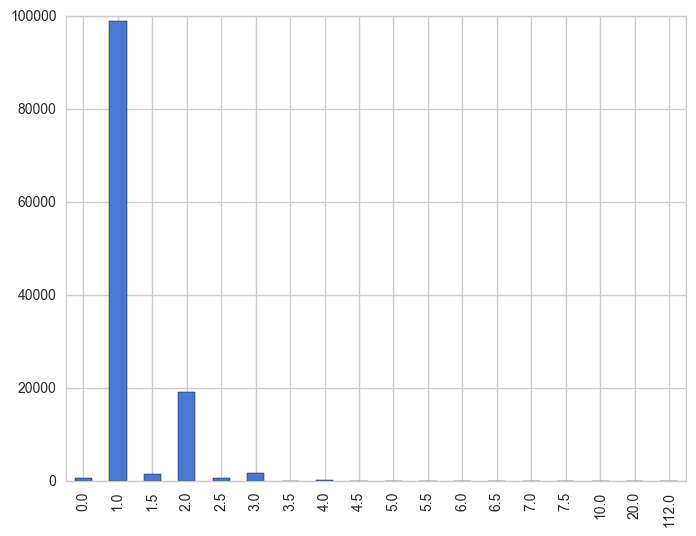

In [6]:
d.bathrooms.value_counts().sort_index().plot(kind='bar')

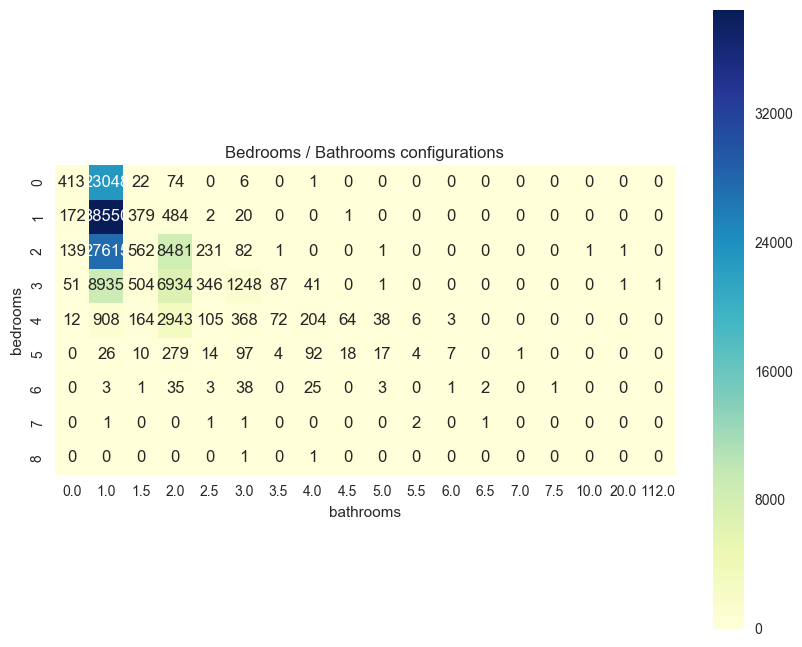

In [7]:
# raw_data.plot.scatter(x='bedrooms', y='bathrooms')
ct = pd.crosstab(raw_data.bedrooms, raw_data.bathrooms)
ct
plt.figure(figsize=(10,8))
ax = sns.heatmap(
        data=ct,
        annot=True,
        fmt='d',
        square=True,
        cmap='YlGnBu')
_ = ax.set_xlabel('bathrooms')
_ = ax.set_ylabel('bedrooms')
_ = ax.set_title('Bedrooms / Bathrooms configurations')

In [8]:
raw_data[raw_data.bathrooms > 7]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
id,,,,,,,,,,,,,,,
104459,10.0,2,424f8014bddc288d26da5fe81d0bea02,1460176471000,"***The building?s well-attended lobby welcomes the residents with its 24-hour doorman and concierge service as well as a fitness center, private storage rooms, bicycle storage, sauna and a laundry area on every floor. Many units have been completely renovated with beautiful new finishes, stone countertops and GE stainless steel appliances. Enjoy the Broadway theater district, Times Square, Central Park and exceptional dining and shopping<br /><br />***HUGE AS BIG AS A FOOT BALL FIELD AND FEATURES HIGH CEILING ,BRAND NEW KITCHEN ,MARBLE BATHROOM, TONS OF CLOSET SPACE ,UNOBSTRUCTED CITY VIEWS AND A TON OF LIGHT DUE TO ITS EXPOSURE AND HIGH FLOOR<br /><br />***TO SET UP TIME AND LOCATION CONTACT RUBENS 039-610-8860<br /><br /><p><a website_redacted",W 52 St.,"[Doorman, Elevator, Fitness Center, Laundry in Building, Dogs Allowed, Cats Allowed]",low,40.7633,6849204,-73.9849,0c71a59cb70215fbf49c9dd93efaa172,"[https://photos.renthop.com/2/6849204_1f92b58ab45a9c2119cf5bae708a3864.jpg, https://photos.renthop.com/2/6849204_1ae5954a51b5345f0d884a3cccd46ba6.jpg, https://photos.renthop.com/2/6849204_0782c1a7feeb02b245be78b737a51b9d.jpg, https://photos.renthop.com/2/6849204_1b7803038b0d3af1499aee849085951f.jpg, https://photos.renthop.com/2/6849204_60bb31a548ed1d570ccfa79a09e4b19e.jpg]",3600,260 W 52 St.
17808,112.0,3,33fa7be8ea2ffc6353af117cab78f569,1465276975000,"This is a pretty, charming, prime location 3 bedrooms apartment, with large windows, hardwood floors living room and bedrooms. The kitchen has an ample breakfast bar, all in white appliances and enough amount of cabinets. The bathrooms owns a very neat and clean aspect with all in white ceramic tiles and floor. One of a kind opportunity. Call us for a viewing.AH<br /><br /><p><a website_redacted",East 75th Street,[Hardwood Floors],None,40.7693,7120577,-73.9529,3e1edc05ca35eaecc90766629d22d078,"[https://photos.renthop.com/2/7120577_dea70af49f689356390e08b7e87b7147.jpg, https://photos.renthop.com/2/7120577_1879301659a01b98208ec014dacbc55d.jpg, https://photos.renthop.com/2/7120577_76e9ee0c957ab8ea9ba10c2a12e41cea.jpg, https://photos.renthop.com/2/7120577_5d3068c109a5277d55593ab1cd528e2f.jpg, https://photos.renthop.com/2/7120577_37b33d72876bf14affd34cd81368eaac.jpg]",3700,433 East 75th Street
22737,20.0,2,0,1466653801000,"Large Two Bedrooms Two Bath all renovated full service luxury building features a sleek kitchen with granite countertops, stainless steel appliances, stunning hardwood floors throughout, it's own private terrace, and extremely ample closet space. The Building itself features 24 hour doorman, and Indoor Swimming Pool, Fitness Center, Lounge, On-site Garage, On-site Dry Cleaner and Valet as well as Laundry on Every floor<br /><br />For further information regarding this Gorgeous Apartment feel free to contact me Fitim at (057-048-2286<br /><br /><br /><br /><br /><br /><br /><br /><p><a website_redacted",East 86th Street,"[Balcony, Doorman, Elevator, Laundry in Building, Laundry in Unit, Hardwood Floors, No Fee]",None,40.7779,7204901,-73.9515,0f57223e3bbd5222d9881a442aba0d03,"[https://photos.renthop.com/2/7204901_405ad00ab9e4c94f7dc50437eb0af967.jpg, https://photos.renthop.com/2/7204901_fb32983bd4f92172700787e34a3488fb.jpg, https://photos.renthop.com/2/7204901_06505c86f2dd9ac282f72afcf69a2434.jpg, https://photos.renthop.com/2/7204901_df9a2d3c631c04f595f86eb8158a1b50.jpg, https://photos.renthop.com/2/7204901_3feacf96ba35fe24d17fd833a03914b6.jpg, https://photos.renthop.com/2/7204901_84448f2cc08cee7556d7c41d938b0846.jpg, https://photos.renthop.com/2/7204901_d1f314b9053e8dbcb1a8cb294efb370c.jpg, https://photos.renthop.com/2/7204901_b9c627389536955be470acbf521deac9.jpg]",4900,305 East 86th Street
59812,7.5,6,0,1462946924000,"Park Slope M

After reading the descriptions for the apartment with suspiciously high number of bathrooms, my conclusion is that 
1. 10 or more bathrooms are data recording errors
2. apartments between 5-10 bathrooms are usually real

However, we need to be careful with imputing data errors because these numbers are what people probably see on the website,
so their interest level will be based on these pieces of information.

In [9]:
interest_level_rate = pd.DataFrame()

interest = raw_data.interest_level.value_counts()
interest_level_rate['all types'] = 100 * interest / interest.sum()

for i in sort(raw_data['bathrooms'].unique()):
    x = raw_data[raw_data['bathrooms'] == i].interest_level.value_counts()
    interest_level_rate['{}_bathrooms'.format(i)] = 100*x / x.sum() 

interest_level_rate.transpose().fillna(0)

,low,medium,high
all types,69.468309,22.752877,7.778813
0.0_bathrooms,97.763578,1.916933,0.319489
1.0_bathrooms,67.426818,23.915580,8.657602
1.5_bathrooms,93.798450,6.201550,0.000000
2.0_bathrooms,72.663185,22.023499,5.313316
2.5_bathrooms,98.916968,1.083032,0.000000
3.0_bathrooms,90.067114,8.053691,1.879195
3.5_bathrooms,100.000000,0.000000,0.000000
4.0_bathrooms,94.339623,3.144654,2.515723
4.5_bathrooms,100.000000,0.000000,0.000000


The table above shows interest rates per bathroom counts. 
Taken into consideration the following definition: 
    "A half bath contains a sink and a toilet. 3/4 bath has a shower, sink and toilet. A full bath has all 3 plus a tub."
(http://www.homes.com/question/15848/what-does-1-1-2-bath-means/) 

I'd propose the following bucketing:

0 bathrooms
1 bathrooms (including  1 and 1.5 as well)
2 bathrooms (including 2 and 2.5)
3 and more

# Bathrooms Bucket

In [10]:
def create_buckets(bathroom_cnt):
    if bathroom_cnt == 0:
        return 0
    if bathroom_cnt in [1, 1.5]:
        return 1
    if bathroom_cnt in [2, 2.5]:
        return 2
    else:
        return 3
d.loc[:, 'num_bathrooms_bucket'] = d.bathrooms.map(create_buckets)
d['num_bathrooms_bucket'].value_counts()

/Library/Python/2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Python/2.7/site-packages/pandas/core/indexing.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


1    100728
2     19932
3      2564
0       787
Name: num_bathrooms_bucket, dtype: int64

In [11]:
d

,bathrooms,num_bathrooms_bucket
id,,
0,1.0,1
1,1.0,1
10,1.5,1
100,1.0,1
1000,1.0,1
10000,1.0,1
100000,2.0,2
100001,3.0,3
100002,1.0,1


# Save the Data

In [12]:
d.to_csv('tmp/features_bathrooms.csv')